In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout

import torch.utils.data as data_utils
import torch

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import time
import scipy.stats as ss


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error,explained_variance_score, mean_absolute_percentage_error

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

In [3]:
data=pd.read_csv('data_final.csv')
data=data.iloc[:,1:]
data

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,Min_ecole,nb_ecole_1kms,nb_ecole_3kms,nb_ecole_5kms,nb_ecole_10kms,nb_ecole_20kms,company_city_count,land_size_correct,size_correct,price_log
0,35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,...,1.049957,0,17,53,227,653,408.0,NaN,63.0,12.779876
1,35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,...,0.180002,11,56,153,644,1155,517.0,NaN,90.0,12.154785
2,35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,...,0.667630,1,3,10,17,97,145.0,370.0,61.0,10.571343
3,35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,...,0.120038,2,2,5,28,142,257.0,764.0,142.0,12.608202
4,35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,...,0.980819,1,107,329,807,1141,1275.0,NaN,88.0,13.077368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37345,35881571,appartement,43.480292,-1.484324,bayonne,64100,2995.0,NaN,NaN,255.0,...,0.189290,12,57,94,146,241,844.0,NaN,2995.0,12.154785
37346,35890109,appartement,48.861391,2.401158,paris-20eme,75020,36.0,4.0,NaN,229.0,...,0.230631,53,500,962,2802,5716,2887.0,NaN,36.0,12.896719
37347,36010245,appartement,44.397837,-1.164312,biscarrosse,40600,99.0,2.0,NaN,NaN,...,0.176353,4,7,7,15,24,137.0,NaN,99.0,12.700772
37348,35864579,duplex,48.864204,2.808693,magny-le-hongre,77700,9281.0,NaN,NaN,NaN,...,0.169916,5,30,58,160,804,158.0,NaN,9281.0,13.045484


In [4]:
target='price'
data['price_log']=np.log1p(data[target])
target_log='price_log'
data['price_log']

0        12.779876
1        12.154785
2        10.571343
3        12.608202
4        13.077368
           ...    
37345    12.154785
37346    12.896719
37347    12.700772
37348    13.045484
37349    11.155264
Name: price_log, Length: 37350, dtype: float64

In [5]:
numerical_features_orgin=['approximate_latitude','approximate_longitude','size_correct','floor','land_size_correct', \
                          'energy_performance_value','ghg_value','nb_rooms','nb_bedrooms','nb_bathrooms',\
                          'nb_parking_places','nb_boxes','nb_photos','has_a_balcony','nb_terraces','has_a_cellar',\
                          'has_a_garage','has_air_conditioning','last_floor','upper_floors','postal_code',] 
additional_n_features= ['ecole_count', 'Min_gare', 'nb_gare_1kms', 'nb_gare_3kms',\
                        'nb_gare_5kms', 'nb_gare_10kms', 'nb_gare_20kms', 'Min_ecole',\
                        'nb_ecole_1kms', 'nb_ecole_3kms', 'nb_ecole_5kms',\
                        'nb_ecole_10kms', 'nb_ecole_20kms', 'company_city_count']

keep_additional_features=['ecole_count','Min_ecole','nb_ecole_1kms','Min_gare','nb_gare_1kms',\
                          'nb_gare_20kms','company_city_count']

numerical_features=numerical_features_orgin+keep_additional_features

categorical_features=['property_type','city','energy_performance_category','ghg_category','exposition']

features_all=numerical_features+categorical_features

target='price_log'

In [6]:
# première analyse de correlation et importances des features : Drop : code postal, nb_rooms, longitude, latitude
list_sup=['nb_rooms','city','last_floor']
for tosup in list_sup:
    features_all.remove(tosup)
    if tosup in numerical_features:
        numerical_features.remove(tosup)
    if tosup in categorical_features:
        categorical_features.remove(tosup)
    
features_all

['approximate_latitude',
 'approximate_longitude',
 'size_correct',
 'floor',
 'land_size_correct',
 'energy_performance_value',
 'ghg_value',
 'nb_bedrooms',
 'nb_bathrooms',
 'nb_parking_places',
 'nb_boxes',
 'nb_photos',
 'has_a_balcony',
 'nb_terraces',
 'has_a_cellar',
 'has_a_garage',
 'has_air_conditioning',
 'upper_floors',
 'postal_code',
 'ecole_count',
 'Min_ecole',
 'nb_ecole_1kms',
 'Min_gare',
 'nb_gare_1kms',
 'nb_gare_20kms',
 'company_city_count',
 'property_type',
 'energy_performance_category',
 'ghg_category',
 'exposition']

In [7]:
numerical_features_0=['floor','land_size_correct']
numerical_features_mean=[i for i in numerical_features if not i in numerical_features_0]

print(numerical_features_0)
numerical_features_mean

['floor', 'land_size_correct']


['approximate_latitude',
 'approximate_longitude',
 'size_correct',
 'energy_performance_value',
 'ghg_value',
 'nb_bedrooms',
 'nb_bathrooms',
 'nb_parking_places',
 'nb_boxes',
 'nb_photos',
 'has_a_balcony',
 'nb_terraces',
 'has_a_cellar',
 'has_a_garage',
 'has_air_conditioning',
 'upper_floors',
 'postal_code',
 'ecole_count',
 'Min_ecole',
 'nb_ecole_1kms',
 'Min_gare',
 'nb_gare_1kms',
 'nb_gare_20kms',
 'company_city_count']

In [8]:
X = data[features_all]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

In [25]:
#Fonctions permettant d'afficher des résultats

def metrics_score(y_real,y_pred):
    mean_squared_error1 = round(mean_squared_error(y_real, y_pred),4)
    explained_variance_score1 = round(explained_variance_score(y_real, y_pred),4)
    mean_absolute_percentage_error1 = round(mean_absolute_percentage_error(y_real, y_pred),4)
    return({'mean_squared_error' : mean_squared_error1,
            'explained_variance_score' : explained_variance_score1,
            'mean_absolute_percentage_error' : mean_absolute_percentage_error1*100,
           })


def score_log_normal(X_train,X_test,y_train,y_test,model):
    y_pred_train_log = model.predict(X_train)
    y_pred_test_log = model.predict(X_test)
    y_pred_train = np.expm1(y_pred_train_log)
    y_pred_test = np.expm1(y_pred_test_log)
    
    
    dic_train_log=metrics_score(y_train,y_pred_train_log)
    dic_test_log=metrics_score(y_test,y_pred_test_log) 
    tab_score_log=pd.DataFrame(dic_train_log.values(),index=list(dic_train_log.keys()),columns=['Train'])
    tab_score_log['Test']=dic_test_log.values()
    print('\033[1m' +'Sur prix Log'+ '\033[0m')
    print(tab_score_log,end='\n\n')
    
    dic_train=metrics_score(np.expm1(y_train),y_pred_train)
    dic_test=metrics_score(np.expm1(y_test),y_pred_test)
    
    tab_score=pd.DataFrame(dic_train.values(),index=list(dic_test.keys()),columns=['Train'])
    tab_score['Test']=dic_test.values()
    print('\033[1m' +'Sur prix Normaux'+ '\033[0m')
    print(tab_score)
    return [tab_score_log,tab_score]


def plot_tab_score(all_tab,name_models):
    fig, axs = plt.subplots(3, 2, figsize=(16, 10))
    all_log=[x[0] for x in all_tab]
    all_normal=[x[1] for x in all_tab]
    #name=['RdmForest','Gradient_Boost','Ada_Boost','XGBoost']
    name_metrics=all_log[0].index
    for metric in range(len(name_metrics)):
        for table in all_log:
            #tab_score.iloc[1,:]
            axs[metric,0].plot(table.iloc[metric,:])

            #plt.plot(tab_score_xgb.iloc[1,:])
        axs[metric,0].set_title((name_metrics[metric]))
        axs[metric,0].legend(name_models)
    for metric in range(len(name_metrics)):
        for table in all_normal:
            #tab_score.iloc[1,:]
            axs[metric,1].plot(table.iloc[metric,:])

            #plt.plot(tab_score_xgb.iloc[1,:])
        axs[metric,1].set_title((name_metrics[metric]))
        axs[metric,1].legend(name_models)

### Optimisation sur nos 3 meilleurs modèles : Gradient Boostin, Ada Boosting et XGBoost

In [10]:
base_estimator=DecisionTreeRegressor(max_depth=8,\
                                      min_samples_leaf=2)

models = [('GradientB_reg',GradientBoostingRegressor(loss='lad')),
          ('adaboost',AdaBoostRegressor(random_state=0,learning_rate=0.01,n_estimators=500,loss='linear',\
                          base_estimator=DecisionTreeRegressor())),
          ("xgboost",  XGBRegressor(min_child_weight=0,\
                       gamma=0, subsample=0.7,\
                       colsample_bytree=1.0,\
                       objective='reg:squarederror', nthread=-1,\
#                       eval_metric='mape',\
                       scale_pos_weight=1, seed=27,\
                       reg_alpha=0.00006))
         ]

grids = {'GradientB_reg':{'GradientB_reg__learning_rate': [0.01,0.05,0.1],
                  'GradientB_reg__subsample'    : [1.0,0.9, 0.8],
                  'GradientB_reg__n_estimators' : [300,500],
#                  'GradientB_reg__criterion' : ['friedman_mse','mae'],       
                  'GradientB_reg__max_depth'    : [3,5]},
      "adaboost" : {'adaboost__n_estimators': [100,300],
               'adaboost__learning_rate' :[0.8,0.9,1.0],
               'adaboost__base_estimator__max_depth':[i for i in range(2,7,2)], #Pour atteindre les paramètres du WL
               'adaboost__base_estimator__min_samples_leaf' :[0.01]},
        "xgboost" : { 'xgboost__max_depth': [2,4, 6],
                        'xgboost__n_estimators': [1000, 3000, 5000],
                        'xgboost__learning_rate': [0.09, 0.1,0.11]}
        }

In [11]:
modelOpt_list=[] #Conserver les modèles

numeric_transformer0 = Pipeline(steps=[
                                    ("imputer",SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])# to deal with missing numeric data : 0

numeric_transformer_mean = Pipeline(steps=[
                                    ("imputer",SimpleImputer(strategy="mean")),
                                    ('scaler', StandardScaler())])# to deal with missing numeric data : mean

categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))]) # to deal with missing categorical data 

preproc = ColumnTransformer(transformers=[("num0", numeric_transformer0, numerical_features_0),
                                          ("num_mean", numeric_transformer_mean, numerical_features_mean),
                                          ("cat", categorical_transformer, categorical_features)])

for name, model in models:
    start_time=time.time()
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name],scoring='neg_mean_absolute_percentage_error', cv=3,n_jobs=-1)
    clf.fit(X_train, y_train)
    modelOpt_list.append((name,clf))
    print('\033[1m' + " Results for {}:".format(name) + '\033[0m')
    print(' Returned hyperparameter: {}'.format(clf.best_params_))
    print(' Best regression score in validation set is: {}'.format(round(- clf.best_score_,3)*100))
    print(' Regression score on test is: {}'.format(- clf.score(X_test, y_test)*100),end='\n\n')
    print("--------- %s secondes ---------" % (round(time.time() - start_time,2)))
    print('-----------------------------------------------------')

 Results for GradientB_reg:
 Returned hyperparameter: {'GradientB_reg__learning_rate': 0.1, 'GradientB_reg__max_depth': 5, 'GradientB_reg__n_estimators': 500, 'GradientB_reg__subsample': 0.8}
 Best regression score in validation set is: 2.3
 Regression score on test is: 2.2168971282043084

--------- 2545.47 secondes ---------
-----------------------------------------------------
 Results for adaboost:
 Returned hyperparameter: {'adaboost__base_estimator__max_depth': 6, 'adaboost__base_estimator__min_samples_leaf': 0.01, 'adaboost__learning_rate': 0.9, 'adaboost__n_estimators': 100}
 Best regression score in validation set is: 3.3000000000000003
 Regression score on test is: 3.2586561190584513

--------- 374.53 secondes ---------
-----------------------------------------------------
 Results for xgboost:
 Returned hyperparameter: {'xgboost__learning_rate': 0.09, 'xgboost__max_depth': 6, 'xgboost__n_estimators': 3000}
 Best regression score in validation set is: 2.1
 Regression score on 

In [20]:
all_tab=[]

name=['Gradient_Boost','Ada_Boost','XGBoost']

for i in range(len(modelOpt_list)):
    name_m=modelOpt_list[i][0]
    model=modelOpt_list[i][1].best_estimator_

    print('Résultat pour',name_m,end='\n\n')
    all_tab.append(score_log_normal(X_train,X_test,y_train,y_test,model))
    print('')
    print('#################'*3,end='\n\n')

Résultat pour GradientB_reg

Sur prix Log
                                 Train    Test
mean_squared_error              0.1178  0.1509
explained_variance_score        0.8194  0.7717
mean_absolute_percentage_error  1.8800  2.2200

Sur prix Normaux
                                       Train          Test
mean_squared_error              1.972262e+10  2.599140e+10
explained_variance_score        7.975000e-01  7.380000e-01
mean_absolute_percentage_error  2.517000e+01  3.024000e+01

###################################################

Résultat pour adaboost

Sur prix Log
                                 Train    Test
mean_squared_error              0.2513  0.2668
explained_variance_score        0.6250  0.6062
mean_absolute_percentage_error  3.2200  3.2600

Sur prix Normaux
                                       Train          Test
mean_squared_error              5.016074e+10  5.369692e+10
explained_variance_score        5.337000e-01  5.078000e-01
mean_absolute_percentage_error  4.077000e+

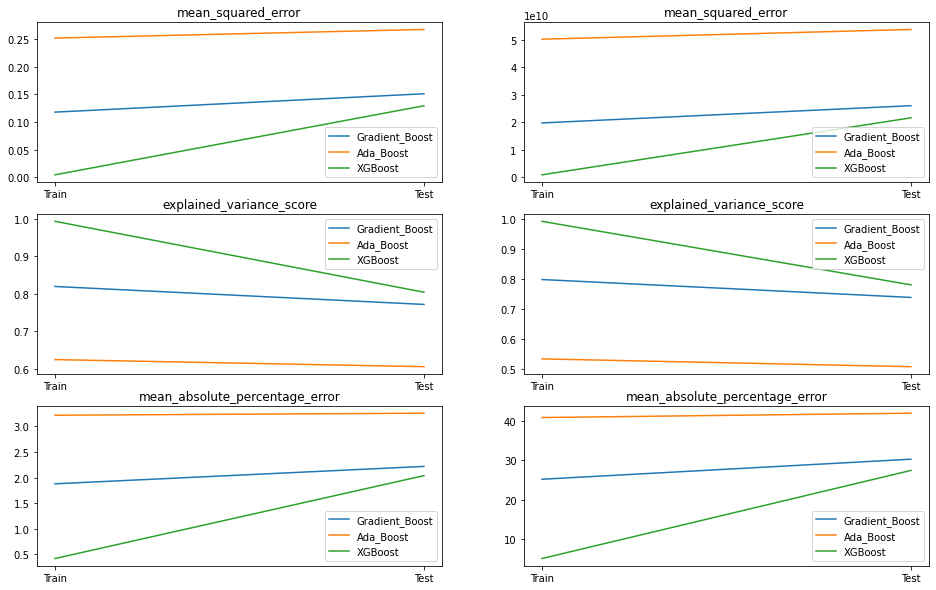

In [26]:
plot_tab_score(all_tab,['Gradient_Boost','Ada_Boost','XGBoost'])

In [ ]:
name_m=modelOpt_list[i][0]
model=modelOpt_list[2][1].best_estimator_

In [35]:
modelOpt_list[0][1].best_params_

{'GradientB_reg__learning_rate': 0.1,
 'GradientB_reg__max_depth': 5,
 'GradientB_reg__n_estimators': 500,
 'GradientB_reg__subsample': 0.8}

In [ ]:
models_BestParam = [('GradientB_reg',GradientBoostingRegressor(loss='lad',learning_rate=0.1,max_depth= 5,\
                                                     n_estimators=500,subsample= 0.8)),
          
          
          ('adaboost',AdaBoostRegressor(random_state=0,learning_rate=0.9,n_estimators=100,loss='linear',\
                          base_estimator=DecisionTreeRegressor(max_depth= 6,min_samples_leaf= 0.01))),
          
          
          ("xgboost",  (min_child_weight=0,learning_rate=0.09,n_estimators= 3000,\
                       gamma=0, subsample=0.7,max_depth= 6,\
                       colsample_bytree=1.0,\
                       objective='reg:squarederror', nthread=-1,\
#                       eval_metric='mape',\ #Ne marche pas sous version mac mais résultats identiques
                       scale_pos_weight=1, seed=27,\
                       reg_alpha=0.00006))
         ]

In [30]:
xgb_opt=XGBRegressor(min_child_weight=0,learning_rate=0.09,n_estimators= 3000,\
                       gamma=0, subsample=0.7,max_depth= 6,\
                       colsample_bytree=1.0,\
                       objective='reg:squarederror', nthread=-1,\
                       eval_metric='mape',\
                       scale_pos_weight=1, seed=27,\
                       reg_alpha=0.00006)

In [31]:
pipe_xgb_opt = Pipeline(steps=[('preprocessor', preproc), ('xgb_opt', xgb_opt)])

In [32]:
pipe_xgb_opt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num0',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['floor',
                                                   'land_size_correct']),
                                                 ('num_mean',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                               

In [33]:
score_xgb_opt=score_log_normal(X_train,X_test,y_train,y_test,pipe_xgb_opt)

Sur prix Log
                                 Train    Test
mean_squared_error              0.0048  0.1293
explained_variance_score        0.9926  0.8041
mean_absolute_percentage_error  0.4200  2.0400

Sur prix Normaux
                                       Train          Test
mean_squared_error              8.679473e+08  2.158104e+10
explained_variance_score        9.910000e-01  7.798000e-01
mean_absolute_percentage_error  5.130000e+00  2.740000e+01


In [78]:
base_estimator=DecisionTreeRegressor(max_depth=8,\
                                      min_samples_leaf=2)

models = [("rdm_frt", RandomForestRegressor(n_jobs= -1)),
          ('GradientB_reg',GradientBoostingRegressor(loss='lad')),
          ('adaboost',AdaBoostRegressor(random_state=0,learning_rate=0.01,n_estimators=500,loss='linear',\
                          base_estimator=DecisionTreeRegressor())),
          ("xgboost",  XGBRegressor(min_child_weight=0,\
                       gamma=0, subsample=0.7,\
                       colsample_bytree=1.0,\
                       objective='reg:squarederror', nthread=-1,\
#                       eval_metric='mape',\
                       scale_pos_weight=1, seed=27,\
                       reg_alpha=0.00006))
         ]

grids = {"rdm_frt" : { 'rdm_frt__max_depth': [4, 6, 8],
#                       'rdm_frt__max_features': ['sqrt','auto'],
                        'rdm_frt__criterion': ['mae', 'mse'], #['mae', 'mse'],['squared_error', 'absolute_error']
#                        'rdm_frt__min_samples_split': [2, 5, 10],
                        'rdm_frt__n_estimators': [300,500]},
         'GradientB_reg':{'GradientB_reg__learning_rate': [0.01,0.05,0.1],
                  'GradientB_reg__subsample'    : [1.0,0.9, 0.8],
                  'GradientB_reg__n_estimators' : [300,500],
#                  'GradientB_reg__criterion' : ['friedman_mse','mae'],       
                  'GradientB_reg__max_depth'    : [3,5]},
      "adaboost" : {'adaboost__n_estimators': [100,300],
               'adaboost__learning_rate' :[0.8,0.9,1.0],
               'adaboost__base_estimator__max_depth':[i for i in range(2,7,2)], #Pour atteindre les paramètres du WL
               'adaboost__base_estimator__min_samples_leaf' :[0.01]},
        "xgboost" : { 'xgboost__max_depth': [2,4, 6],
                        'xgboost__n_estimators': [1000, 3000, 5000],
                        'xgboost__learning_rate': [0.09, 0.1,0.11]}
        }

## Neural Network : 

Nous allons à présent mettre en place différents réseaux nous permettant de prédire le prix des biens immobiliers.

In [34]:
# Preprocessing des données (Valeurs manquantes, Encoder) Pour Neural Network

def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            df[col].fillna('Unknown')
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)
            df.drop([col],axis = 1 , inplace=True)
    return df


def Preprocess(df,numerical_features_mean,numerical_features_0,categorical_features):
    numeric_transformer0 = Pipeline(steps=[
                                    ("imputer",SimpleImputer(strategy="constant", fill_value=0)),
                                    ('scaler', StandardScaler())])# to deal with missing numeric data : 0

    numeric_transformer_mean = Pipeline(steps=[
                                    ("imputer",SimpleImputer(strategy="mean")),
                                    ('scaler', StandardScaler())])# to deal with missing numeric data : mean

    imputer_cat=SimpleImputer(strategy="constant", fill_value="Not defined")
    for num_mean in numerical_features_mean:
        df[num_mean]=numeric_transformer0.fit_transform(df[[num_mean]])

    for num_0 in numerical_features_0:
        df[num_0]=numeric_transformer0.fit_transform(df[[num_0]])

    for cat in categorical_features:
        df[cat]=imputer_cat.fit_transform(df[[cat]])

    df=oneHotEncode(df,categorical_features)

    return df

In [35]:
print('Nombre colonne avant oneHotEncoder : {}'.format(X.shape[1]))
X_N = Preprocess(X, numerical_features_mean,numerical_features_0,categorical_features)
#X_testN = Preprocess(X_testN, numerical_features_mean,numerical_features_0,categorical_features)
print('Nombre colonne apres oneHotEncoder : {}'.format(X_N.shape[1]))

Nombre colonne avant oneHotEncoder : 30


C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_mean]=numeric_transformer0.fit_transform(df[[num_mean]])
C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_mean]=numeric_transformer0.fit_transform(df[[num_mean]])
C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_mean]=numeric_transformer0.fit_transform(df[[num_mean]])
C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_mean]=numeric_transformer0.fit_transform(df[[num_mean]])
C:\Users\NOVACL~1\AppData\Local\Temp/ipykernel_10784/902986183.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

KeyError: "None of [Index(['land_size'], dtype='object')] are in the [columns]"

In [37]:
X_trainN, X_testN, y_trainN, y_testN = train_test_split(X_N,data[target], test_size=0.2, random_state = 42)

In [57]:
# Création du Neural Network

NN_model=Sequential()
NN_model.add(Dense(128,kernel_initializer='normal',input_dim=X_trainN.shape[1],activation='relu'))
NN_model.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(rate=0.1))
NN_model.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1,kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error','mse','msle'])
NN_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               9856      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               65792     
                                                                 
 dense_21 (Dense)            (None, 1)                 257       
                                                                 
Total params: 108,929
Trainable params: 108,929
Non-trainable params: 0
_________________________________________________________________


In [58]:
history=NN_model.fit(X_trainN,y_trainN, batch_size=32, epochs=100,validation_split = 0.2)

Epoch 1/100
747/747 [==============================] - 4s 5ms/step - loss: 8.0270 - mean_absolute_error: 0.9974 - mse: 5.9957 - msle: 0.0902 - val_loss: 4.0582 - val_mean_absolute_error: 0.5075 - val_mse: 0.4441 - val_msle: 0.0025
Epoch 2/100
747/747 [==============================] - 4s 5ms/step - loss: 4.6564 - mean_absolute_error: 0.5768 - mse: 0.7682 - msle: 0.0033 - val_loss: 4.1603 - val_mean_absolute_error: 0.5229 - val_mse: 0.4598 - val_msle: 0.0026
Epoch 3/100
747/747 [==============================] - 3s 4ms/step - loss: 4.4727 - mean_absolute_error: 0.5542 - mse: 0.5816 - msle: 0.0030 - val_loss: 3.7927 - val_mean_absolute_error: 0.4670 - val_mse: 0.4255 - val_msle: 0.0022
Epoch 4/100
747/747 [==============================] - 3s 4ms/step - loss: 4.3691 - mean_absolute_error: 0.5408 - mse: 0.7569 - msle: 0.0029 - val_loss: 4.0226 - val_mean_absolute_error: 0.5014 - val_mse: 0.4210 - val_msle: 0.0023
Epoch 5/100
747/747 [==============================] - 3s 4ms/step - loss: 4

Epoch 36/100
747/747 [==============================] - 3s 4ms/step - loss: 2.5854 - mean_absolute_error: 0.3189 - mse: 0.1912 - msle: 0.0011 - val_loss: 2.8716 - val_mean_absolute_error: 0.3560 - val_mse: 0.2288 - val_msle: 0.0013
Epoch 37/100
747/747 [==============================] - 3s 4ms/step - loss: 2.5795 - mean_absolute_error: 0.3182 - mse: 0.1933 - msle: 0.0011 - val_loss: 2.9419 - val_mean_absolute_error: 0.3621 - val_mse: 0.2328 - val_msle: 0.0013
Epoch 38/100
747/747 [==============================] - 3s 4ms/step - loss: 2.5651 - mean_absolute_error: 0.3163 - mse: 0.1894 - msle: 0.0011 - val_loss: 2.9514 - val_mean_absolute_error: 0.3662 - val_mse: 0.2401 - val_msle: 0.0013
Epoch 39/100
747/747 [==============================] - 4s 5ms/step - loss: 2.5240 - mean_absolute_error: 0.3112 - mse: 0.1850 - msle: 0.0011 - val_loss: 3.0053 - val_mean_absolute_error: 0.3735 - val_mse: 0.2465 - val_msle: 0.0014
Epoch 40/100
747/747 [==============================] - 4s 5ms/step - lo

Epoch 71/100
747/747 [==============================] - 3s 4ms/step - loss: 2.1076 - mean_absolute_error: 0.2600 - mse: 0.1366 - msle: 7.7638e-04 - val_loss: 2.8755 - val_mean_absolute_error: 0.3532 - val_mse: 0.2238 - val_msle: 0.0013
Epoch 72/100
747/747 [==============================] - 3s 4ms/step - loss: 2.1004 - mean_absolute_error: 0.2593 - mse: 0.1344 - msle: 7.6370e-04 - val_loss: 2.9295 - val_mean_absolute_error: 0.3605 - val_mse: 0.2350 - val_msle: 0.0013
Epoch 73/100
747/747 [==============================] - 3s 4ms/step - loss: 2.1043 - mean_absolute_error: 0.2596 - mse: 0.1358 - msle: 7.7167e-04 - val_loss: 2.9569 - val_mean_absolute_error: 0.3683 - val_mse: 0.2427 - val_msle: 0.0014
Epoch 74/100
747/747 [==============================] - 3s 4ms/step - loss: 2.0854 - mean_absolute_error: 0.2575 - mse: 0.1375 - msle: 7.6610e-04 - val_loss: 2.9310 - val_mean_absolute_error: 0.3633 - val_mse: 0.2421 - val_msle: 0.0014
Epoch 75/100
747/747 [==============================] - 

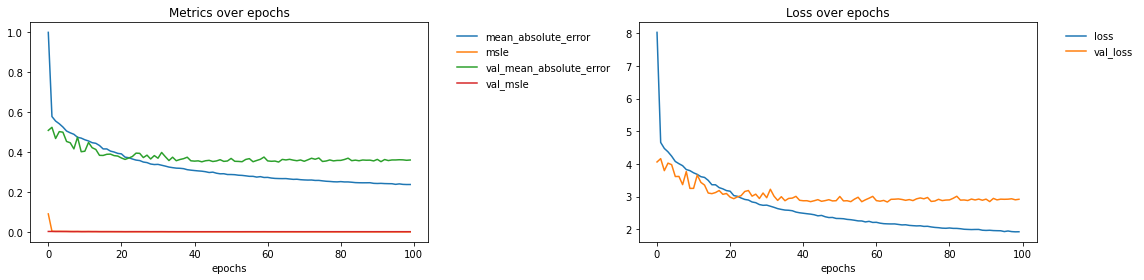

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

axs[0].plot(history.history["mean_absolute_error"], label="mean_absolute_error")
#axs[0].plot(history.history["mse"], label="mse")
axs[0].plot(history.history["msle"], label="msle")


axs[0].plot(history.history["val_mean_absolute_error"], label="val_mean_absolute_error")
#axs[0].plot(history.history["val_mse"], label="val_mse")
axs[0].plot(history.history["val_msle"], label="val_msle")


axs[0].set_title("Metrics over epochs")
axs[0].set_xlabel("epochs")

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")

axs[1].set_title("Loss over epochs")
axs[1].set_xlabel("epochs")
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

In [61]:
tab_NN=score_log_normal(X_trainN,X_testN,y_trainN,y_testN,NN_model)

Sur prix Log
                                 Train    Test
mean_squared_error              0.1270  0.2538
explained_variance_score        0.8054  0.6157
mean_absolute_percentage_error  1.9600  3.0200

Sur prix Normaux
                                       Train          Test
mean_squared_error              4.636328e+10  4.440502e+10
explained_variance_score        5.141000e-01  5.446000e-01
mean_absolute_percentage_error  2.552000e+01  4.152000e+01


On constate qu'à partir de 20 époques le réseau à tendance à overfitter. Nous nous limitons donc à un nombre de 20 époques. On obtient une mean_absolute_percentage_error de 41.5.

In [62]:
NN_model=Sequential()
NN_model.add(Dense(128,kernel_initializer='normal',input_dim=X_trainN.shape[1],activation='relu'))
NN_model.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(rate=0.1))
NN_model.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(1,kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error','mse','msle'])
NN_model.summary()

history=NN_model.fit(X_trainN,y_trainN, batch_size=32, epochs=20,validation_split = 0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               9856      
                                                                 
 dense_23 (Dense)            (None, 256)               33024     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 108,929
Trainable params: 108,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
747/747 [============================

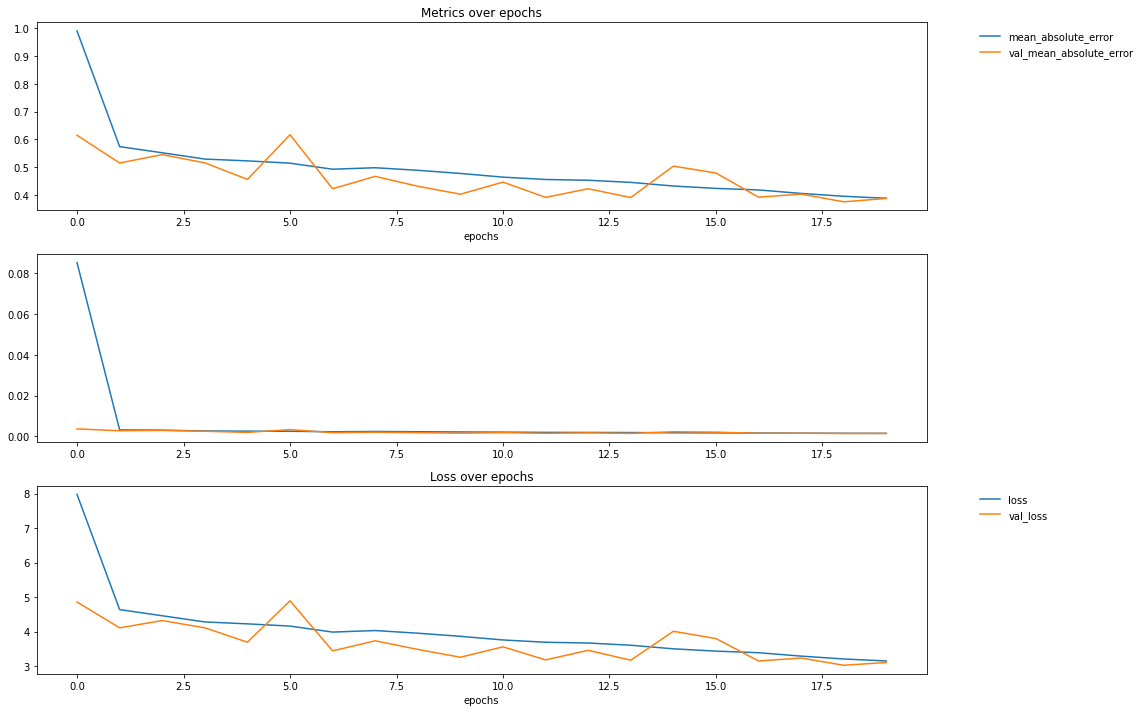

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

axs[0].plot(history.history["mean_absolute_error"], label="mean_absolute_error")
#axs[0].plot(history.history["mse"], label="mse")
axs[1].plot(history.history["msle"], label="msle")


axs[0].plot(history.history["val_mean_absolute_error"], label="val_mean_absolute_error")
#axs[0].plot(history.history["val_mse"], label="val_mse")
axs[1].plot(history.history["val_msle"], label="val_msle")


axs[0].set_title("Metrics over epochs")
axs[0].set_xlabel("epochs")

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

axs[2].plot(history.history["loss"], label="loss")
axs[2].plot(history.history["val_loss"], label="val_loss")

axs[2].set_title("Loss over epochs")
axs[2].set_xlabel("epochs")
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

In [64]:
tab_NN=score_log_normal(X_trainN,X_testN,y_trainN,y_testN,NN_model)

Sur prix Log
                                 Train    Test
mean_squared_error              0.2534  0.2802
explained_variance_score        0.6505  0.6153
mean_absolute_percentage_error  3.0100  3.1600

Sur prix Normaux
                                       Train          Test
mean_squared_error              4.722904e+10  5.153101e+10
explained_variance_score        5.720000e-01  5.378000e-01
mean_absolute_percentage_error  3.473000e+01  3.685000e+01


Avec un nombre d'époque limité à 20, les résultats s'améliore et nous obtenons une précision de 36.8 sur le test.
Nous allons essayer un nouveau réseau avec une couche en moins afin d'évaluer si il est meilleur ou non.

In [50]:
# Création du Neural Network : Plus court

NN_model2=Sequential()
NN_model2.add(Dense(128,kernel_initializer='normal',input_dim=X_trainN.shape[1],activation='relu'))
NN_model2.add(Dropout(rate=0.1))
NN_model2.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(1,kernel_initializer='normal',activation='linear'))

NN_model2.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error','mse','msle'])
NN_model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               9856      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               33024     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________


In [51]:
history2=NN_model2.fit(X_trainN,y_trainN, batch_size=32, epochs=100,validation_split = 0.2)

Epoch 1/100
747/747 [==============================] - 3s 4ms/step - loss: 9.3178 - mean_absolute_error: 1.1602 - mse: 8.2173 - msle: 0.1248 - val_loss: 4.2670 - val_mean_absolute_error: 0.5347 - val_mse: 0.6334 - val_msle: 0.0030
Epoch 2/100
747/747 [==============================] - 3s 3ms/step - loss: 5.0043 - mean_absolute_error: 0.6218 - mse: 1.0491 - msle: 0.0039 - val_loss: 4.4744 - val_mean_absolute_error: 0.5646 - val_mse: 0.5266 - val_msle: 0.0029
Epoch 3/100
747/747 [==============================] - 3s 4ms/step - loss: 4.6606 - mean_absolute_error: 0.5780 - mse: 0.6609 - msle: 0.0032 - val_loss: 5.4018 - val_mean_absolute_error: 0.6844 - val_mse: 0.6818 - val_msle: 0.0039
Epoch 4/100
747/747 [==============================] - 3s 4ms/step - loss: 4.4880 - mean_absolute_error: 0.5559 - mse: 0.5288 - msle: 0.0029 - val_loss: 3.5166 - val_mean_absolute_error: 0.4367 - val_mse: 0.3264 - val_msle: 0.0018
Epoch 5/100
747/747 [==============================] - 3s 4ms/step - loss: 4

747/747 [==============================] - 3s 4ms/step - loss: 2.5439 - mean_absolute_error: 0.3139 - mse: 0.1962 - msle: 0.0011 - val_loss: 2.9038 - val_mean_absolute_error: 0.3600 - val_mse: 0.2490 - val_msle: 0.0014
Epoch 72/100
747/747 [==============================] - 3s 3ms/step - loss: 2.5559 - mean_absolute_error: 0.3154 - mse: 0.1974 - msle: 0.0012 - val_loss: 2.9185 - val_mean_absolute_error: 0.3622 - val_mse: 0.2365 - val_msle: 0.0013
Epoch 73/100
747/747 [==============================] - 3s 4ms/step - loss: 2.5405 - mean_absolute_error: 0.3136 - mse: 0.2733 - msle: 0.0011 - val_loss: 2.9445 - val_mean_absolute_error: 0.3613 - val_mse: 0.2419 - val_msle: 0.0014
Epoch 74/100
747/747 [==============================] - 3s 3ms/step - loss: 2.5514 - mean_absolute_error: 0.3149 - mse: 0.1999 - msle: 0.0011 - val_loss: 2.8814 - val_mean_absolute_error: 0.3538 - val_mse: 0.2305 - val_msle: 0.0013
Epoch 75/100
747/747 [==============================] - 2s 3ms/step - loss: 2.5343 - 

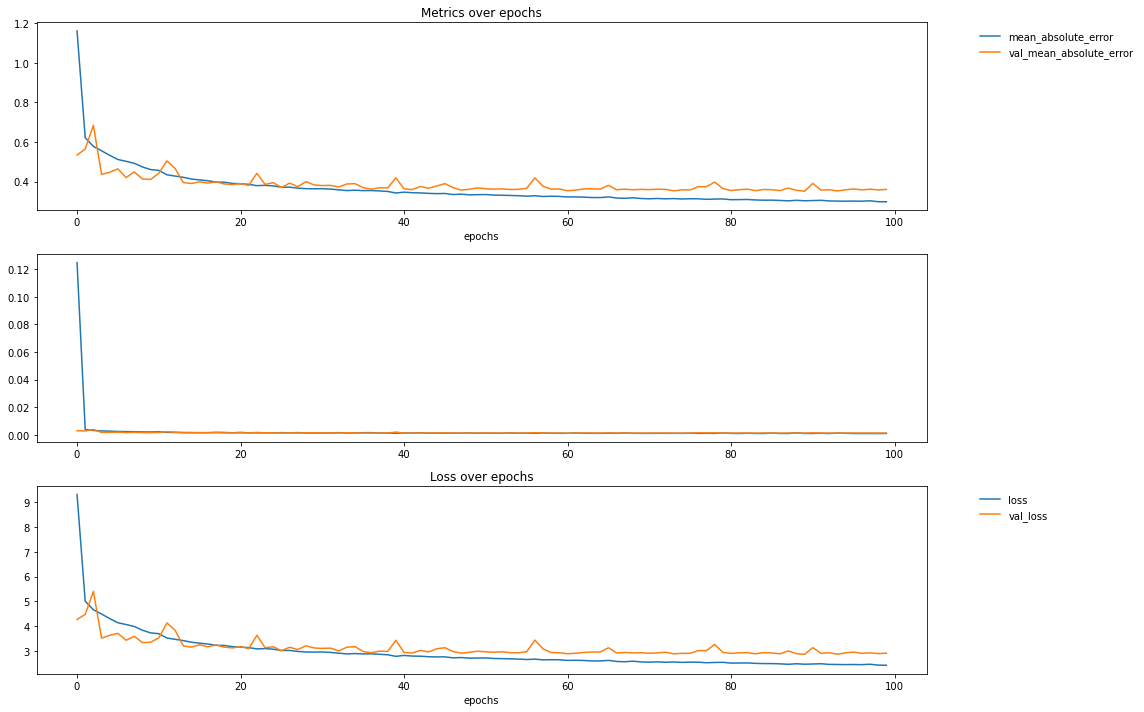

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

axs[0].plot(history2.history["mean_absolute_error"], label="mean_absolute_error")
#axs[0].plot(history.history["mse"], label="mse")
axs[1].plot(history2.history["msle"], label="msle")


axs[0].plot(history2.history["val_mean_absolute_error"], label="val_mean_absolute_error")
#axs[0].plot(history.history["val_mse"], label="val_mse")
axs[1].plot(history2.history["val_msle"], label="val_msle")


axs[0].set_title("Metrics over epochs")
axs[0].set_xlabel("epochs")

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

axs[2].plot(history2.history["loss"], label="loss")
axs[2].plot(history2.history["val_loss"], label="val_loss")

axs[2].set_title("Loss over epochs")
axs[2].set_xlabel("epochs")
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

In [53]:
tab_NN=score_log_normal(X_trainN,X_testN,y_trainN,y_testN,NN_model2)

Sur prix Log
                                 Train    Test
mean_squared_error              0.1830  0.2536
explained_variance_score        0.7327  0.6280
mean_absolute_percentage_error  2.3200  2.9400

Sur prix Normaux
                                       Train          Test
mean_squared_error              3.238974e+15  2.012846e+12
explained_variance_score       -3.413258e+04 -1.977190e+01
mean_absolute_percentage_error  4.812000e+01  4.182000e+01


Dans ce cas de figure, nous constatons que le nombre d'époque optimal tourne autour de 40. La précision avec 100 époques n'est pas bonne. Nous relançons donc l'entrainement sur une quarantaine d'époques.

In [68]:
NN_model2=Sequential()
NN_model2.add(Dense(128,kernel_initializer='normal',input_dim=X_trainN.shape[1],activation='relu'))
NN_model2.add(Dropout(rate=0.1))
NN_model2.add(Dense(256,kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(1,kernel_initializer='normal',activation='linear'))

NN_model2.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_error','mse','msle'])
NN_model2.summary()

history2=NN_model2.fit(X_trainN,y_trainN, batch_size=32, epochs=35,validation_split = 0.2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               9856      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                                 
 dense_31 (Dense)            (None, 1)                 257       
                                                                 
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________
Epoch 1/35
747/747 [==============================] - 4s 4ms/step - loss: 9.2274 - mean_absolute_error: 1.1468 - mse: 6.5324 - msle: 0.1239 - val_loss: 4.1645 - val_mean_absolute_err

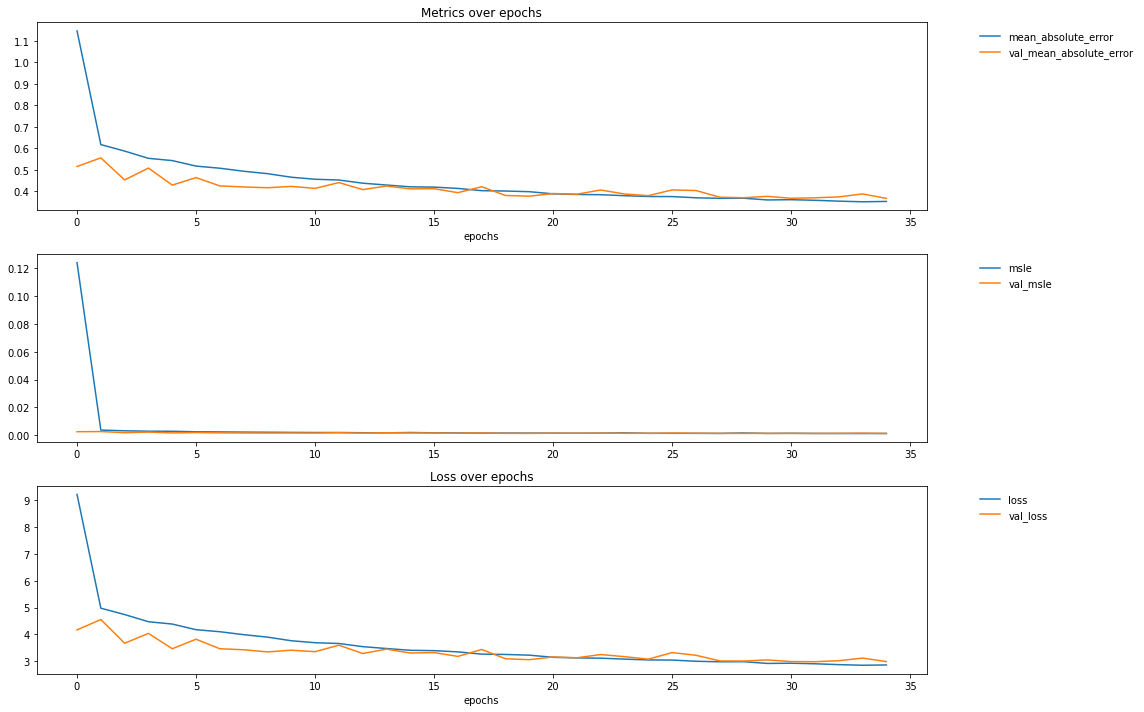

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

axs[0].plot(history2.history["mean_absolute_error"], label="mean_absolute_error")
#axs[0].plot(history.history["mse"], label="mse")
axs[1].plot(history2.history["msle"], label="msle")


axs[0].plot(history2.history["val_mean_absolute_error"], label="val_mean_absolute_error")
#axs[0].plot(history.history["val_mse"], label="val_mse")
axs[1].plot(history2.history["val_msle"], label="val_msle")


axs[0].set_title("Metrics over epochs")
axs[0].set_xlabel("epochs")

axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

axs[2].plot(history2.history["loss"], label="loss")
axs[2].plot(history2.history["val_loss"], label="val_loss")

axs[2].set_title("Loss over epochs")
axs[2].set_xlabel("epochs")
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

fig.tight_layout()
plt.show()

In [70]:
tab_NN=score_log_normal(X_trainN,X_testN,y_trainN,y_testN,NN_model2)

Sur prix Log
                                 Train    Test
mean_squared_error              0.2209  0.2493
explained_variance_score        0.6638  0.6262
mean_absolute_percentage_error  2.7100  3.0100

Sur prix Normaux
                                       Train          Test
mean_squared_error              4.489911e+22  6.414168e+10
explained_variance_score       -4.731602e+11  3.385000e-01
mean_absolute_percentage_error  1.442522e+05  4.330000e+01
